In [2]:
#Library Import 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import Ridge, Lasso
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.ensemble import RandomForestRegressor
import optuna
import warnings

# Ignore warnings 
warnings.filterwarnings('ignore')


# 2. Data Modeling (LinearRegression, RandomForest)
#### 2.1 Major Road Data

In [3]:
#Load File
df = pd.read_excel('laei-2019-major-roads-vkm-flows-speeds.xlsx')

In [4]:
print('Before Cleaning : ' ,df.shape)

#Remove hyphen
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)
df.replace('-', np.nan, inplace=True)

#Missing value Handling
df = df.dropna()

#Rename columns
df.columns = [x.strip() for x in df.columns]
df = df.rename(columns ={'Speed (km/hr) - Except Buses':'Speed'})

#Drop total columns
df = df.drop(['AADT 2019 - Total','VKM 2019 - Total'],axis=1)

print('After Cleaning : ' ,df.shape)

Before Cleaning :  (79437, 48)
After Cleaning :  (44826, 46)


In [5]:
#Handling AADT and VKM data
id_col = ['TOID','LAEI Zone', 'Borough', 'Road Classification','Speed','Link Length (m)']
aadt_col = [col for col in df.columns if col.startswith('AADT')]
vkm_col = [col for col in df.columns if col.startswith('VKM')]

In [6]:
#For AADT data
df_aadt = df[id_col + aadt_col]
df_aadt['Car'] = df_aadt['AADT Petrol Car'] + df_aadt['AADT Diesel Car'] + df_aadt['AADT Taxi']
df_aadt['Public Transport'] = df_aadt['AADT 2019 - Buses'] + df_aadt['AADT 2019 - Coaches']
df_aadt['PHV'] = df_aadt['AADT Petrol PHV'] + df_aadt['AADT Diesel PHV']
df_aadt['LGV'] = df_aadt['AADT Petrol LGV'] + df_aadt['AADT Diesel LGV']
df_aadt['Rigid'] = df_aadt['AADT 2019 - HGVs - Rigid - 2 Axles'] + df_aadt['AADT 2019 - HGVs - Rigid - 3 Axles'] + df_aadt['AADT 2019 - HGVs - Rigid - 4 or more Axles']
df_aadt['Artic'] = df_aadt['AADT 2019 - HGVs - Articulated - 3 to 4 Axles'] + df_aadt['AADT 2019 - HGVs - Articulated - 5 Axles'] + df_aadt['AADT 2019 - HGVs - Articulated - 6 Axles']
aadt_col = ['Car','Public Transport','PHV','LGV','Rigid','Artic']
df_aadt = df_aadt.melt(id_vars=id_col,
                  value_vars=aadt_col, var_name='VehicleType', value_name='AADT')

df_aadt['VehicleType'] = df_aadt['VehicleType'].str.replace('AADT 2019 - ','')
df_aadt['VehicleType'] = df_aadt['VehicleType'].str.replace('AADT ','')

df_aadt.head()

,TOID,LAEI Zone,Borough,Road Classification,Speed,Link Length (m),VehicleType,AADT
0,osgb4000000030400377,Non-GLA,Non-GLA,A Road,44.0,22,Car,5898.0
1,osgb4000000030151183,Non-GLA,Non-GLA,A Road,37.0,105,Car,6228.0
2,osgb4000000030090345,Non-GLA,Non-GLA,A Road,46.0,187,Car,3828.0
3,osgb4000000027948232,Non-GLA,Non-GLA,A Road,34.0,51,Car,7465.0
4,osgb4000000030078494,Non-GLA,Non-GLA,A Road,42.0,511,Car,13680.0


In [7]:
#For VKM data
df_vkm = df[id_col + vkm_col]
df_vkm['Car'] = df_vkm['VKM Petrol Car'] + df_vkm['VKM Diesel Car'] + df_vkm['VKM Taxi']
df_vkm['Public Transport'] = df_vkm['VKM 2019 - Buses'] + df_vkm['VKM 2019 - Coaches']
df_vkm['PHV'] = df_vkm['VKM Petrol PHV'] + df_vkm['VKM Diesel PHV']
df_vkm['LGV'] = df_vkm['VKM Petrol LGV'] + df_vkm['VKM Diesel LGV']
df_vkm['Rigid'] = df_vkm['VKM 2019 - HGVs - Rigid - 2 Axles'] + df_vkm['VKM 2019 - HGVs - Rigid - 3 Axles'] + df_vkm['VKM 2019 - HGVs - Rigid - 4 or more Axles']
df_vkm['Artic'] = df_vkm['VKM 2019 - HGVs - Articulated - 3 to 4 Axles'] + df_vkm['VKM 2019 - HGVs - Articulated - 5 Axles'] + df_vkm['VKM 2019 - HGVs - Articulated - 6 Axles']
vkm_col = ['Car','Public Transport','PHV','LGV','Rigid','Artic']
df_vkm = df_vkm.melt(id_vars=id_col,
                  value_vars=vkm_col, var_name='VehicleType', value_name='VKM')

df_vkm.head()

,TOID,LAEI Zone,Borough,Road Classification,Speed,Link Length (m),VehicleType,VKM
0,osgb4000000030400377,Non-GLA,Non-GLA,A Road,44.0,22,Car,47357.0
1,osgb4000000030151183,Non-GLA,Non-GLA,A Road,37.0,105,Car,238209.0
2,osgb4000000030090345,Non-GLA,Non-GLA,A Road,46.0,187,Car,261606.0
3,osgb4000000027948232,Non-GLA,Non-GLA,A Road,34.0,51,Car,138959.0
4,osgb4000000030078494,Non-GLA,Non-GLA,A Road,42.0,511,Car,2551410.0


In [8]:
#Merge AADT and VKM data
df_clean = pd.merge(df_aadt, df_vkm, on=id_col + ['VehicleType'], how='inner')

df_clean.shape

(268956, 9)

In [9]:
#Check datatype
df_clean.dtypes

TOID                    object
LAEI Zone               object
Borough                 object
Road Classification     object
Speed                  float64
Link Length (m)          int64
VehicleType             object
AADT                   float64
VKM                    float64
dtype: object

In [10]:
#Check VehicleType
df_clean.VehicleType.unique()

array(['Car', 'Public Transport', 'PHV', 'LGV', 'Rigid', 'Artic'],
      dtype=object)

### 2.2 Emission Data

In [11]:
#Load Data - Choose Co2 sheet
emission = pd.read_excel('LAEI2019-nox-pm-co2-major-roads-link-emissions.xlsx',sheet_name='CO2 Road Link Emissions')

In [12]:
#Missing value Handling
print('Before Cleaning : ' ,emission.shape)
emission = emission.dropna()
print('After Cleaning : ' ,emission.shape)

Before Cleaning :  (79439, 51)
After Cleaning :  (79372, 51)


In [13]:
#Handling emission data
TargetYear_col = [col for col in emission.columns if col.endswith('2019') or col in ['TOID', 'pollutant', 'emissions-units']]
emission = emission[TargetYear_col]
emission['Car'] = emission['Road-Car-Petrol-2019'] + emission['Road-Car-Diesel-2019'] + emission['Road-Taxi-2019']
emission['Public Transport'] = emission['Road-TfL-Bus-2019'] + emission['Road-Non-TfL-Bus-or-Coach-2019']
emission['PHV'] = emission['Road-PHV-Petrol-2019'] + emission['Road-PHV-Diesel-2019']
emission['LGV'] = emission['Road-LGV-Petrol-2019'] + emission['Road-LGV-Diesel-2019']
emission['Rigid'] = emission['Road-HGV-Rigid-2019']
emission['Artic'] = emission['Road-HGV-Articulated-2019']
emission_col = ['Car','Public Transport','PHV','LGV','Rigid','Artic']
emission = emission[['TOID']+emission_col]

emission.head()


,TOID,Car,Public Transport,PHV,LGV,Rigid,Artic
0,osgb4000000027865913,4475.104067,287.478165,135.608199,1444.578881,719.907087,812.958826
1,osgb4000000027865914,4408.603867,340.049210,153.854622,1907.114693,874.143183,988.081118
2,osgb4000000027865915,5005.822564,130.965613,350.688776,2395.623183,1603.731357,5817.421752
3,osgb4000000027865916,5680.263177,155.428179,337.417918,2518.839822,1774.656002,6425.954597
4,osgb4000000027865917,3392.920660,111.135284,200.001553,1788.899661,993.792755,3599.797813


In [14]:
#Melt table for VehicleType
emission_clean = emission.melt(id_vars=['TOID'],
                       value_vars=emission_col, var_name='VehicleType', value_name='Emission Value')

emission_clean.head()

,TOID,VehicleType,Emission Value
0,osgb4000000027865913,Car,4475.104067
1,osgb4000000027865914,Car,4408.603867
2,osgb4000000027865915,Car,5005.822564
3,osgb4000000027865916,Car,5680.263177
4,osgb4000000027865917,Car,3392.920660


### 2.3 Main DataFrame

In [15]:
#Merge table for main dataframe
main_df = pd.merge(df_clean,emission_clean,on=['TOID','VehicleType'],how='inner')
main_df.shape


(268818, 10)

In [16]:
main_df.head()

,TOID,LAEI Zone,Borough,Road Classification,Speed,Link Length (m),VehicleType,AADT,VKM,Emission Value
0,osgb4000000030400377,Non-GLA,Non-GLA,A Road,44.0,22,Car,5898.0,47357.0,6.356939
1,osgb4000000030151183,Non-GLA,Non-GLA,A Road,37.0,105,Car,6228.0,238209.0,34.176009
2,osgb4000000030090345,Non-GLA,Non-GLA,A Road,46.0,187,Car,3828.0,261606.0,34.818740
3,osgb4000000027948232,Non-GLA,Non-GLA,A Road,34.0,51,Car,7465.0,138959.0,20.812516
4,osgb4000000030078494,Non-GLA,Non-GLA,A Road,42.0,511,Car,13680.0,2551410.0,348.135065


### 2.4 LinearRegression

In [17]:
#Data Proprocessing for the model input
X = main_df.iloc[:, 4:-1]
y = main_df.iloc[:, -1:]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_feature_names = X_train.drop('VehicleType', axis=1).columns.tolist()

# Initialize the OneHotEncoder to encode categorical variables
encoder_one_hot = OneHotEncoder()
X_train_e = encoder_one_hot.fit_transform(X_train['VehicleType'].values.reshape(-1, 1))
X_test_e = encoder_one_hot.transform(X_test['VehicleType'].values.reshape(-1, 1))

# Initialize the StandardScaler to standardize numerical features
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train.drop('VehicleType',axis=1))
X_test_num = scaler.transform(X_test.drop('VehicleType',axis=1))

X_train = np.hstack((X_train_e.toarray(), X_train_num))
X_test = np.hstack((X_test_e.toarray(), X_test_num))

# Concatenate the one-hot encoded feature names with the numeric feature names
one_hot_feature_names = encoder_one_hot.get_feature_names_out(['VehicleType'])
all_feature_names = np.concatenate([one_hot_feature_names, numeric_feature_names])

In [66]:
#Define function for modelling
def ml_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test, model_name='lr', alpha=0.1, cross_val=False, scoring='r2',feature_names=all_feature_names):
    # Build the model
    if model_name == 'l1':
        lm = Lasso(alpha=alpha)
    elif model_name == 'l2':
        lm = Ridge(alpha=alpha)
    elif model_name == 'rf':
        lm = RandomForestRegressor(n_estimators=100, random_state=42)
    else:
        lm = LinearRegression(fit_intercept=True)

    # Cross-validation
    if cross_val:
        scores = cross_val_score(lm, X_train, y_train, cv=5, scoring=scoring)
        return {scoring: scores, f'Average of {scoring}': scores.mean()}

    # Fit the model and predict
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test)
  
    # Flatten y_test and y_pred to avoid shape mismatch errors
    y_test_flat = y_test.values.ravel()  # Flatten y_test (in case it's a DataFrame)
    y_pred_flat = y_pred.ravel()  # Flatten y_pred (ensure it's a 1D array)

    # Metrics
    mae = mean_absolute_error(y_test_flat, y_pred_flat)
    mse = mean_squared_error(y_test_flat, y_pred_flat)
    r2 = r2_score(y_test_flat, y_pred_flat)


    # Regression Line Plot
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_flat, y_pred_flat, color="blue", label='Data Points')
    m, b = np.polyfit(y_test_flat, y_pred_flat, 1)  # 1D arrays for y_test and y_pred
    plt.plot(y_test_flat, m * y_test_flat + b, color="red", label="Best Fit Line", linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Regression Line Plot {model_name}')
    plt.legend()
    plt.show()

    # Plot R^2
    if model_name not in ('rf'):
        explained_variance = r2
        unexplained_variance = 1 - r2
        plt.figure(figsize=(6, 6))
        plt.bar(['Explained Variance', 'Unexplained Variance'], [explained_variance, unexplained_variance], color=['green', 'red'])
        plt.title('Explained vs Unexplained Variance (R^2)')
        plt.ylabel('Variance Proportion')
        plt.show()
    else:
        return {'MAE': mae, 'MSE': mse, 'R^2': r2}, lm.get_params()

    # Plot feature importance for Lasso or Ridge models
    if model_name in ('l1', 'l2'):
        plt.figure(figsize=(8, 6))
        plt.barh(feature_names.reshape(-1), lm.coef_.reshape(-1), color='blue')  # Horizontal bar chart
        plt.xlabel('Coefficient Value')
        plt.title(f'Feature Importance after {model_name.upper()}')
        plt.show()
    return {'MAE': mae, 'MSE': mse, 'R^2': r2}



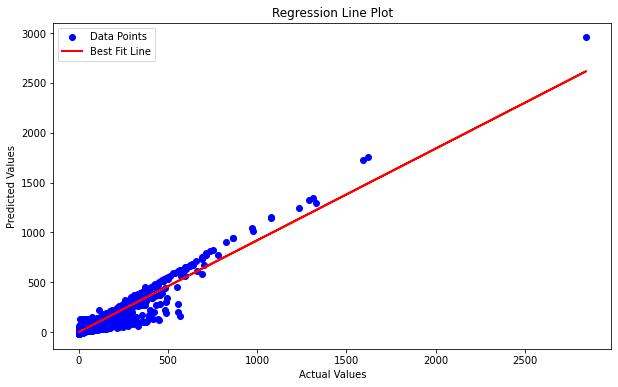

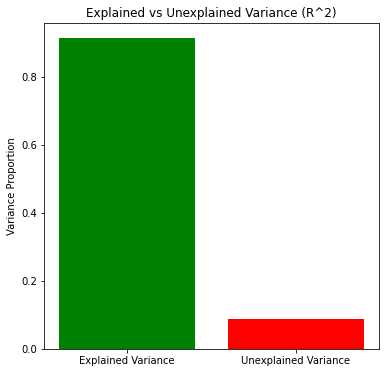

In [19]:
#Running LinearRegression
basic = ml_model()


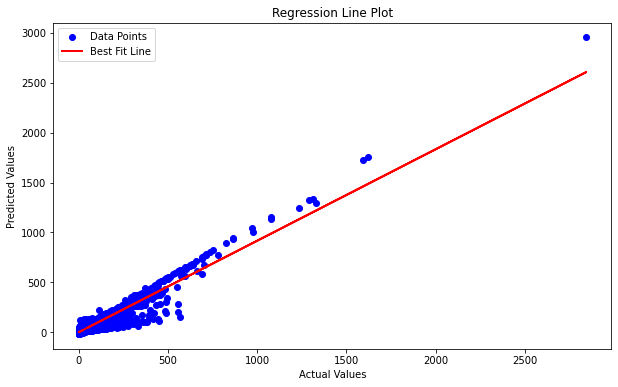

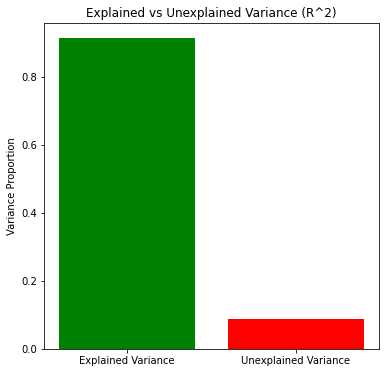

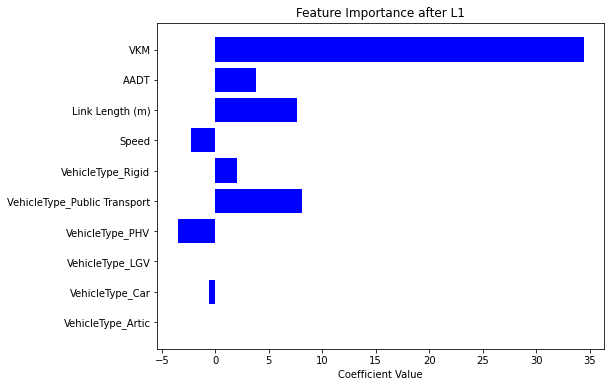

In [20]:
#Add regularisation (Lasso)
reg_l1 = ml_model(model_name='l1')

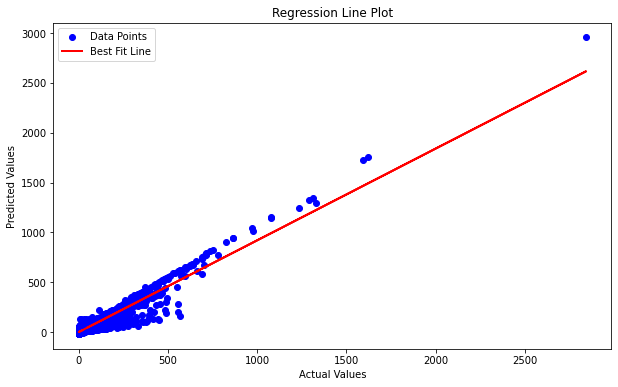

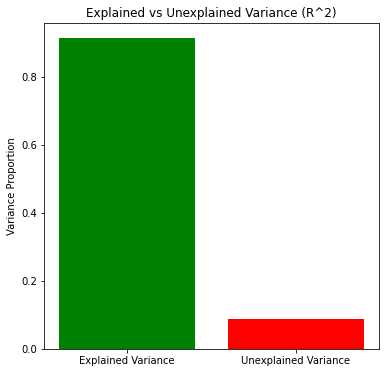

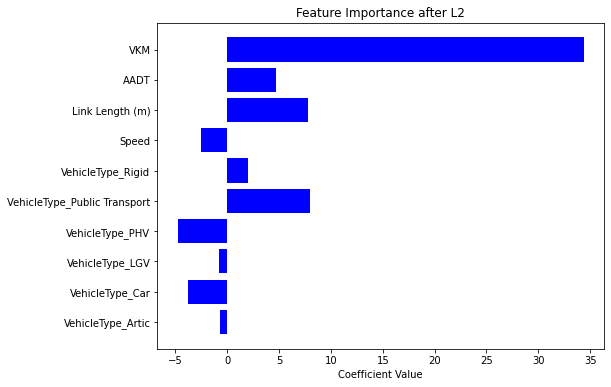

In [21]:
#Add regularisation (Ridge)
reg_l2 = ml_model(model_name='l2')


In [24]:
Summary = pd.DataFrame([basic,reg_l1,reg_l2],index=['LR','Lasso','Ridge'])
Summary

,MAE,MSE,R^2
LR,5.530014,149.341852,0.913057
Lasso,5.446101,149.563762,0.912927
Ridge,5.530887,149.342480,0.913056


#### 2.4.2 CrossValidation

In [89]:
#Use cross validation on MAE to eliminate variance
cv_basic = ml_model(scoring='neg_mean_absolute_error',cross_val=True)
cv_l1 = ml_model(model_name='l1',scoring='neg_mean_absolute_error',alpha=0.2,cross_val=True)
cv_l2 = ml_model(model_name='l2',scoring='neg_mean_absolute_error',alpha=0.2,cross_val=True)
Summary_cv = pd.DataFrame([-cv_basic['neg_mean_absolute_error'],-cv_l1['neg_mean_absolute_error'],-cv_l2['neg_mean_absolute_error']],index=['LR','Lasso','Ridge'])
Summary_cv['Average'] = Summary_cv.mean(axis=1)
Summary_cv

,0,1,2,3,4,Average
LR,5.558314,5.665508,5.577061,5.546225,5.738475,5.617116
Lasso,5.429901,5.531180,5.431218,5.416342,5.600445,5.481817
Ridge,5.562883,5.666353,5.577220,5.546192,5.738479,5.618225


In [88]:
#Use cross validation on R^2 to eliminate variance
cv_basic = ml_model(cross_val=True)
cv_l1 = ml_model(model_name='l1',alpha=0.2,cross_val=True)
cv_l2 = ml_model(model_name='l2',alpha=0.2,cross_val=True)
Summary_cv_r2 = pd.DataFrame([cv_basic['r2'],cv_l1['r2'],cv_l2['r2']],index=['LR','Lasso','Ridge'])
Summary_cv_r2['Average'] = Summary_cv.mean(axis=1)
Summary_cv_r2

,0,1,2,3,4,Average
LR,0.899106,0.878152,0.915583,0.903480,0.890141,0.897292
Lasso,0.898291,0.877285,0.914934,0.902528,0.889123,0.896432
Ridge,0.899111,0.878152,0.915583,0.903480,0.890140,0.897293


### 2.5 RandomForest

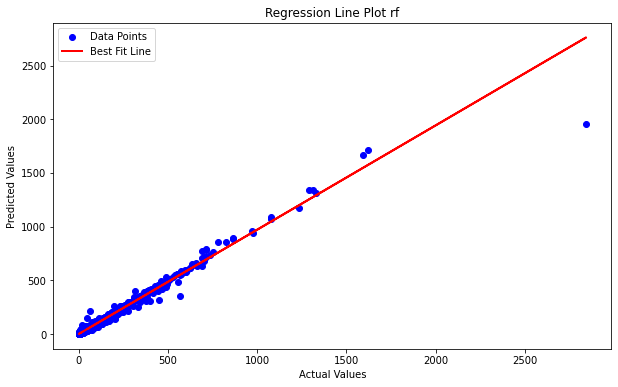

In [67]:
# Running Random Forest
rf, rf_param = ml_model(model_name='rf')

In [41]:
basic_rf = {'MAE': rf['MAE'], 'MSE': rf['MSE'], 'R^2': rf['R^2'] }
basic_rf

,MAE,MSE,R^2
RandomForest,0.555249,22.169875,0.987093


### 2.5.1 Bayesian Optimization

In [38]:
# Objective function to optimize with Optuna
def objective(trial):
    n_estimators = trial.suggest_int('n_estimators', 100, 200)
    max_depth = trial.suggest_int('max_depth', 1, 20)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 4)
    max_features = trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])

    rf = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf, max_features=max_features, random_state=42)
    
    score = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error').mean()
    return -score

# Create a study and optimize the hyperparameters
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

# Best hyperparameters found by Optuna
print(study.best_params)

[I 2024-10-05 09:16:46,723] A new study created in memory with name: no-name-efb72b80-f0ef-4afd-b5e9-5c7fb9fdac74
[I 2024-10-05 09:18:28,993] Trial 0 finished with value: 3.589683383537667 and parameters: {'n_estimators': 190, 'max_depth': 7, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 0 with value: 3.589683383537667.
[I 2024-10-05 09:19:17,215] Trial 1 finished with value: 8.568943198101568 and parameters: {'n_estimators': 193, 'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 'sqrt'}. Best is trial 0 with value: 3.589683383537667.
[I 2024-10-05 09:21:45,452] Trial 2 finished with value: 0.9552391553907145 and parameters: {'n_estimators': 144, 'max_depth': 19, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'log2'}. Best is trial 2 with value: 0.9552391553907145.
[I 2024-10-05 09:24:28,188] Trial 3 finished with value: 0.8604198522344835 and parameters: {'n_estimators': 145, 'max_depth': 19, 'min_sa

{'n_estimators': 145, 'max_depth': 19, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt'}


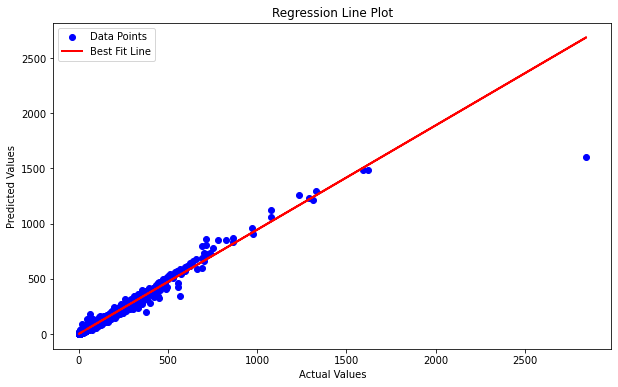

{'MAE': 0.7917848032030124,
 'MSE': 40.97114007268818,
 'R^2': 0.9761475217022011}

In [62]:
# Build a Random Forest with best parameters from Bayesian Optimization
best_params = study.best_params
best_rf = RandomForestRegressor(**best_params, random_state=42)
best_rf.fit(X_train, y_train)
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rf_bo = {'MAE':mae,'MSE':mse,'R^2':r2}

def reg_line_plot(y_test=y_test,y_pred=y_pred):
    y_test_flat = y_test.values.ravel()  # Flatten y_test (in case it's a DataFrame)
    y_pred_flat = y_pred.ravel()  # Flatten y_pred (ensure it's a 1D array)
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_flat, y_pred_flat, color="blue", label='Data Points')
    m, b = np.polyfit(y_test_flat, y_pred_flat, 1)  # 1D arrays for y_test and y_pred
    plt.plot(y_test_flat, m * y_test_flat + b, color="red", label="Best Fit Line", linewidth=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Regression Line Plot')
    plt.legend()
    plt.show()

reg_line_plot()
rf_bo

In [91]:
Summary_rf = pd.DataFrame([basic_rf,rf_bo],index=['RandomForest','RandomForest_BO'])
Summary_rf

,MAE,MSE,R^2
RandomForest,0.555249,22.169875,0.987093
RandomForest_BO,0.791785,40.971140,0.976148


In [68]:
# Paramter Comparison
rf = RandomForestRegressor(n_estimators=100, random_state=42)
pd.DataFrame([rf_param,best_rf.get_params()],index=['RandomForest','RandomForest_BO'])

,bootstrap,ccp_alpha,criterion,max_depth,max_features,max_leaf_nodes,max_samples,min_impurity_decrease,min_samples_leaf,min_samples_split,min_weight_fraction_leaf,n_estimators,n_jobs,oob_score,random_state,verbose,warm_start
RandomForest,True,0.0,squared_error,NaN,auto,None,None,0.0,1,2,0.0,100,None,False,42,0,False
RandomForest_BO,True,0.0,squared_error,19.0,sqrt,None,None,0.0,2,5,0.0,145,None,False,42,0,False


#### 2.5.2 CrossValidation

In [44]:
# Use cross validation on mae to eliminate variance
rf_cv = ml_model(model_name='rf',cross_val=True,scoring='neg_mean_absolute_error')
rf_bo_cv = cross_val_score(best_rf, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')

In [94]:
summary_rf_cv = pd.DataFrame([-rf_cv['neg_mean_absolute_error'],-rf_bo_cv],index=['RandomForest','RandomForest_BO'])
summary_rf_cv['Average'] = summary_rf_cv.mean(axis=1)
summary_rf_cv

,0,1,2,3,4,Average
RandomForest,0.561428,0.617249,0.554859,0.578402,0.612139,0.584815
RandomForest_BO,0.846818,0.880642,0.847602,0.828125,0.898912,0.860420


### 2.6 Neural Network

In [73]:
#Define function for modelling

def nn_model(X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

    model = Sequential([
        Dense(64, input_dim=X_train.shape[1], activation='relu'),  # First hidden layer
        Dropout(0.3),  # Dropout to prevent overfitting
        Dense(32, activation='relu'),  # Second hidden layer
        Dropout(0.3),
        Dense(16, activation='relu'),  # Third hidden layer
        Dense(1, activation='linear')  # Output layer for regression (CO2 emissions)
    ])

    model.compile(optimizer='adam',  # Adam optimizer is usually a good choice
                loss='mean_squared_error',  # Loss function for regression
                metrics=['mean_absolute_error'])  # MAE is a good metric for regression

    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,callbacks=[early_stopping])

    test_loss, test_mae = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

    return history, {'MAE':test_mae, 'MSE':test_loss}

In [81]:
def plot_performance(history):
    # Create subplots for loss
    fig, axs = plt.subplots(figsize=(10, 10))

    axs.plot(history.history['loss'], label='Training Loss')
    axs.plot(history.history['val_loss'], label='Validation Loss')
    axs.set_title('Model Loss')
    axs.set_xlabel('Epochs')
    axs.set_ylabel('Loss (MSE)')
    axs.legend(loc='upper right')
    axs.grid(True)
    # Display the plot
    plt.tight_layout()
    plt.show()

In [75]:
# Training
history, mae_nn = nn_model()


Epoch 1/100
5377/5377 [==============================] - 9s 2ms/step - loss: 278.1355 - mean_absolute_error: 5.8226 - val_loss: 121.7667 - val_mean_absolute_error: 3.2949
Epoch 2/100
5377/5377 [==============================] - 7s 1ms/step - loss: 156.4984 - mean_absolute_error: 4.2403 - val_loss: 85.9532 - val_mean_absolute_error: 2.5857
Epoch 3/100
5377/5377 [==============================] - 8s 1ms/step - loss: 140.6225 - mean_absolute_error: 3.9103 - val_loss: 82.1062 - val_mean_absolute_error: 2.7808
Epoch 4/100
5377/5377 [==============================] - 8s 1ms/step - loss: 128.8148 - mean_absolute_error: 3.7690 - val_loss: 65.9403 - val_mean_absolute_error: 2.6130
Epoch 5/100
5377/5377 [==============================] - 8s 1ms/step - loss: 119.8905 - mean_absolute_error: 3.6826 - val_loss: 59.4197 - val_mean_absolute_error: 2.6078
Epoch 6/100
5377/5377 [==============================] - 8s 2ms/step - loss: 111.4263 - mean_absolute_error: 3.5984 - val_loss: 78.6461 - val_mean_ab

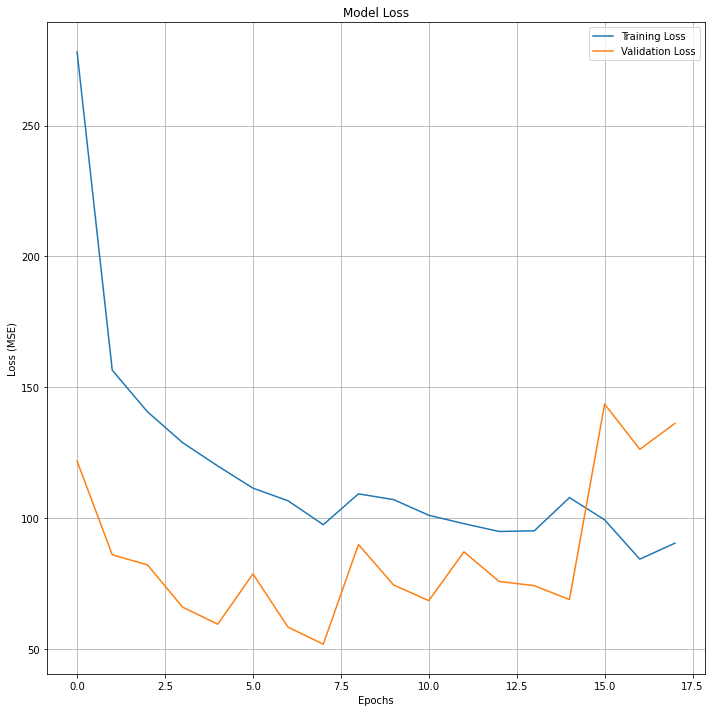

Early stopping occurred at epoch: 18
Best epoch (where weights were restored): 8


,MAE,MSE
NeuralNetwork,2.851023,34.822956


In [84]:
#Performance over epochs
plot_performance(history)

#Early Stopping and Restore best weights
early_stopping_epoch = len(history.epoch) 
print(f"Early stopping occurred at epoch: {early_stopping_epoch}")
val_loss_history = history.history['val_loss'] 
best_epoch = val_loss_history.index(min(val_loss_history)) + 1
print(f"Best epoch (where weights were restored): {best_epoch}")

nn_summary = pd.DataFrame(mae_nn,index=['NeuralNetwork'])
nn_summary

### 2.7 Modelling Summary

In [85]:
#All model metrics summary
pd.concat([Summary,Summary_rf,nn_summary])

,MAE,MSE,R^2
LR,5.530014,149.341852,0.913057
Lasso,5.446101,149.563762,0.912927
Ridge,5.530887,149.342480,0.913056
RandomForest,0.555249,22.169875,0.987093
RandomForest_BO,0.791785,40.971140,0.976148
NeuralNetwork,2.851023,34.822956,NaN


In [95]:
#With Cross Validation to eliminate variance
pd.concat([Summary_cv,summary_rf_cv])

,0,1,2,3,4,Average
LR,5.558314,5.665508,5.577061,5.546225,5.738475,5.617116
Lasso,5.429901,5.531180,5.431218,5.416342,5.600445,5.481817
Ridge,5.562883,5.666353,5.577220,5.546192,5.738479,5.618225
RandomForest,0.561428,0.617249,0.554859,0.578402,0.612139,0.584815
RandomForest_BO,0.846818,0.880642,0.847602,0.828125,0.898912,0.860420


In [92]:
#All model summary
pd.concat([Summary,Summary_rf,nn_summary])

,MAE,MSE,R^2
LR,5.530014,149.341852,0.913057
Lasso,5.446101,149.563762,0.912927
Ridge,5.530887,149.342480,0.913056
RandomForest,0.555249,22.169875,0.987093
RandomForest_BO,0.791785,40.971140,0.976148
NeuralNetwork,2.851023,34.822956,NaN
